In [3]:
# clean annotated data
def merge_tag(sent):
    '''
    Merge the tags that are split by the tokenizer

    Args:
        sent: a sentence with tags
    '''
    i = 0
    while i < len(sent["tags"]):
        if sent["tags"][i]["word"].startswith("##"):
            sent["tags"][i-1]["word"] += sent["tags"][i]["word"][2:]
            del sent["tags"][i]
        else:
            i += 1

# for book in annotated_books:
#     for sentence in book:
#         merge_tag(sentence)

for sentence in annotated_parents:
    merge_tag(sentence)

In [6]:
def bio_to_tags(sent):
    '''
    Convert BIO tag to tag

    Args:
        sent: a sentence json object
    '''
    pre_tag = None
    accumulative = 0
    i = 0
    while i < len(sent["tags"]):
        tag = sent["tags"][i]
        entity = tag["entity"]
        if entity.startswith("B-"):
            tag["entity"] = entity[2:]
            pre_tag = tag
            accumulative = 0
            i += 1
        elif entity.startswith("I-"):
            if pre_tag is None:
                sent["tags"].pop(i)
                accumulative = 0
            elif pre_tag["index"] == tag["index"] - 1 - accumulative:
                pre_tag["end"] = tag["end"]
                pre_tag["word"] = sent["sentence"][pre_tag["start"]:pre_tag["end"]].lower()
                sent["tags"].pop(i)
                accumulative += 1
            else:
                sent["tags"].pop(i)
                accumulative = 0
        else:
            # throw error
            print(tag)
            Exception("Invalid tag")

for sentence in annotated_parents:
        bio_to_tags(sentence)

In [1]:
# import the data for books

import json

with open('/Users/sunnyyu/Desktop/Children_Speech_Books_NLP/data/quantifiers/BOOKS_QUANTIFIERS.json', 'r') as file:
    generics_data = json.load(file)

In [35]:
# examine all the generics in the book dataset

from collections import defaultdict

excluded_pronouns = {'he', 'you', 'we', 'she', 'i', 'they', 'him', 'her', 'them', 'his', 'hers', 'theirs', 'it'}

# Initialize the dictionary to store counts
tag_categories = {
    'Non-Living Kind': defaultdict(int),
    'Social Kind/Role': defaultdict(int),
    'Biological Kind': defaultdict(int),
    'Artifacts': defaultdict(int)
}


def process_and_print_generics_sentences(book_data):
    generics_sentences = defaultdict(list)  # Dictionary to store generics sentences per entity

    for book in book_data:
        for sentence_data in book:
            subjects = sentence_data.get('subjects', [])
            tags = sentence_data.get('tags', [])
            category = sentence_data.get('category')
            quantifier = sentence_data.get('quantified_classification')
            sentence_text = sentence_data.get('sentence', 'No sentence provided')
            
            #if category == 3:  # Check if the category is for generics
            if category == 3: # change to 4 for analyzing habituals
                for subject_info in subjects:
                    subject = subject_info['subject'].lower()
                    if subject not in excluded_pronouns:  # Ensure the subject is not a pronoun
                        for tag in tags:
                            if subject == tag['word'].lower():
                                entity = tag['entity']
                                if entity in tag_categories:
                                    generics_sentences[entity].append(sentence_text)

    # Print the generics sentences for each entity kind
    for entity, sentences in generics_sentences.items():
        print(f"Entity: {entity}")
        for sentence in sentences:
            print(f"  Sentence: {sentence}")

# Example usage:
process_and_print_generics_sentences(generics_data)

Entity: Biological Kind
  Sentence: The steeper the road, the faster you go.
  Sentence: Much like a skateboard, you turn by leaning.
  Sentence: Riders are going faster than they should and cannot turn sharply enough.
  Sentence: Ferrets like to play with other ferrets, so you might want to think about getting more than one.
  Sentence: Since they’re hunters, they have sharp teeth, so you’ll have to play with your ferret carefully.
  Sentence: Since they’re hunters, they have sharp teeth, so you’ll have to play with your ferret carefully.
  Sentence: Since they’re hunters, they have sharp teeth, so you’ll have to play with your ferret carefully.
  Sentence: Since they’re hunters, they have sharp teeth, so you’ll have to play with your ferret carefully.
  Sentence: Since they’re hunters, they have sharp teeth, so you’ll have to play with your ferret carefully.
  Sentence: Chinchillas are rodents, which means they need to chew on things.
  Sentence: They’ll need hard branches to chew on

In [23]:
import json
from collections import defaultdict
from scipy.stats import ttest_ind

# Initialize the dictionary to store counts
tag_categories = {
    'Non-Living Kind': defaultdict(int),
    'Social Kind/Role': defaultdict(int),
    'Biological Kind': defaultdict(int),
    'Artifacts': defaultdict(int)
}

# Set of pronouns to exclude from "Biological Kind"
excluded_pronouns = {'he', 'you', 'we', 'she', 'i', 'they', 'him', 'her', 'them', 'his', 'hers', 'theirs', 'it'}

# Function to process each book's sentences
def process_book(book):
    for sentence_data in book:
        subjects = sentence_data.get('subjects', [])
        tags = sentence_data.get('tags', [])
        category = sentence_data.get('category')
        
        for subject_info in subjects:
            subject = subject_info['subject'].lower()
            if subject not in excluded_pronouns:  # Check if the subject is not a pronoun
                for tag in tags:
                    if subject == tag['word'].lower():
                        entity = tag['entity']
                        if entity in tag_categories:
                            tag_categories[entity][category] += 1

# Process each book in the data
for book in generics_data:
    process_book(book)

# Convert defaultdict to dict for better readability
tag_categories = {k: dict(v) for k, v in tag_categories.items()}

# Calculate the total count for each tag category
total_counts = {entity: sum(categories.values()) for entity, categories in tag_categories.items()}

# Calculate proportions
tag_proportions = {
    entity: {category: count / total_counts[entity] for category, count in categories.items()}
    for entity, categories in tag_categories.items()
}

# Prepare data for t-test
# Collect all category counts as a baseline (e.g., overall counts)
overall_counts = defaultdict(int)
for categories in tag_categories.values():
    for category, count in categories.items():
        overall_counts[category] += count

overall_total = sum(overall_counts.values())
overall_proportions = {category: count / overall_total for category, count in overall_counts.items()}

# Perform t-tests and print results
print("T-Test Results:")
for entity, categories in tag_categories.items():
    print(f"\nEntity: {entity}")
    for category, count in categories.items():
        proportion = tag_proportions[entity][category]

        # Prepare data for t-test
        entity_samples = [1] * count + [0] * (total_counts[entity] - count)
        baseline_samples = [1] * overall_counts[category] + [0] * (overall_total - overall_counts[category])

        # Perform t-test
        t_stat, p_value = ttest_ind(entity_samples, baseline_samples, equal_var=False)

        # Print results
        print(f"  Category {category}:")
        print(f"    Count = {count}")
        print(f"    Proportion = {proportion:.2%}")
        print(f"    T-Statistic = {t_stat:.2f}, P-Value = {p_value:.4f}")


T-Test Results:

Entity: Non-Living Kind
  Category 1:
    Count = 886
    Proportion = 33.43%
    T-Statistic = 0.81, P-Value = 0.4162
  Category 0:
    Count = 1147
    Proportion = 43.28%
    T-Statistic = 4.34, P-Value = 0.0000
  Category 8:
    Count = 173
    Proportion = 6.53%
    T-Statistic = 6.80, P-Value = 0.0000
  Category 3:
    Count = 66
    Proportion = 2.49%
    T-Statistic = -0.15, P-Value = 0.8780
  Category 4:
    Count = 42
    Proportion = 1.58%
    T-Statistic = 0.32, P-Value = 0.7500
  Category 2:
    Count = 104
    Proportion = 3.92%
    T-Statistic = -21.78, P-Value = 0.0000
  Category 5:
    Count = 77
    Proportion = 2.91%
    T-Statistic = -1.23, P-Value = 0.2188
  Category 6:
    Count = 26
    Proportion = 0.98%
    T-Statistic = -0.23, P-Value = 0.8151
  Category 9:
    Count = 104
    Proportion = 3.92%
    T-Statistic = 2.29, P-Value = 0.0219
  Category 7:
    Count = 25
    Proportion = 0.94%
    T-Statistic = 1.83, P-Value = 0.0668

Entity: Social 

In [26]:
# universal quantifiers t-tests

import json
from collections import defaultdict
from scipy.stats import ttest_ind

# Initialize the dictionary to store counts
tag_categories = {
    'Non-Living Kind': defaultdict(int),
    'Social Kind/Role': defaultdict(int),
    'Biological Kind': defaultdict(int),
    'Artifacts': defaultdict(int)
}

# Set of pronouns to exclude from "Biological Kind"
excluded_pronouns = {'he', 'you', 'we', 'she', 'i', 'they', 'him', 'her', 'them', 'his', 'hers', 'theirs', 'it'}

# Function to process each book's sentences
def process_book(book):
    for sentence_data in book:
        subjects = sentence_data.get('subjects', [])
        tags = sentence_data.get('tags', [])
        category = sentence_data.get('category')
        quantifier = sentence_data.get('quantified_classification')
        
        # Only process Universal Quantifier sentences
        if quantifier == "Universal Quantifier":
            for subject_info in subjects:
                subject = subject_info['subject'].lower()
                if subject not in excluded_pronouns:  # Check if the subject is not a pronoun
                    for tag in tags:
                        if subject == tag['word'].lower():
                            entity = tag['entity']
                            if entity in tag_categories:
                                tag_categories[entity][category] += 1

# Process each book in the data
for book in generics_data:
    process_book(book)

# Convert defaultdict to dict for better readability
tag_categories = {k: dict(v) for k, v in tag_categories.items()}

# Calculate the total count for each tag category
total_counts = {entity: sum(categories.values()) for entity, categories in tag_categories.items()}

# Calculate proportions
tag_proportions = {
    entity: {category: count / total_counts[entity] for category, count in categories.items()}
    for entity, categories in tag_categories.items()
}

# Prepare data for t-test
# Collect all category counts as a baseline (e.g., overall counts)
overall_counts = defaultdict(int)
for categories in tag_categories.values():
    for category, count in categories.items():
        overall_counts[category] += count

overall_total = sum(overall_counts.values())
overall_proportions = {category: count / overall_total for category, count in overall_counts.items()}

# Perform t-tests and print results
print("T-Test Results:")
for entity, categories in tag_categories.items():
    print(f"\nEntity: {entity}")
    for category, count in categories.items():
        proportion = tag_proportions[entity][category]

        # Prepare data for t-test
        entity_samples = [1] * count + [0] * (total_counts[entity] - count)
        baseline_samples = [1] * overall_counts[category] + [0] * (overall_total - overall_counts[category])

        # Perform t-test
        t_stat, p_value = ttest_ind(entity_samples, baseline_samples, equal_var=False)

        # Print results
        print(f"  Category {category}:")
        print(f"    Count = {count}")
        print(f"    Proportion = {proportion:.2%}")
        print(f"    T-Statistic = {t_stat:.2f}, P-Value = {p_value:.4f}")



T-Test Results:

Entity: Non-Living Kind
  Category 3:
    Count = 6
    Proportion = 9.84%
    T-Statistic = 1.34, P-Value = 0.1852
  Category 1:
    Count = 4
    Proportion = 6.56%
    T-Statistic = -1.82, P-Value = 0.0727
  Category 5:
    Count = 1
    Proportion = 1.64%
    T-Statistic = 0.11, P-Value = 0.9099
  Category 0:
    Count = 37
    Proportion = 60.66%
    T-Statistic = 0.74, P-Value = 0.4590
  Category 2:
    Count = 4
    Proportion = 6.56%
    T-Statistic = -0.49, P-Value = 0.6237
  Category 6:
    Count = 1
    Proportion = 1.64%
    T-Statistic = 0.23, P-Value = 0.8152
  Category 8:
    Count = 4
    Proportion = 6.56%
    T-Statistic = -1.08, P-Value = 0.2843
  Category 9:
    Count = 3
    Proportion = 4.92%
    T-Statistic = 0.85, P-Value = 0.3991
  Category 4:
    Count = 1
    Proportion = 1.64%
    T-Statistic = -0.47, P-Value = 0.6412

Entity: Social Kind/Role
  Category 1:
    Count = 30
    Proportion = 28.30%
    T-Statistic = 3.29, P-Value = 0.0013
  Cat

In [7]:
# calculate base rate

# Initialize counters for categories 3 and 4
category_3_count = 0
category_4_count = 0
total_sentences = 0

# Iterate through the generics_data to count occurrences of categories 3 and 4
for book in generics_data:
    for sentence_info in book:
        total_sentences += 1  # Count each sentence
        category = sentence_info['category']
        
        if category == 3:
            category_3_count += 1
        elif category == 4:
            category_4_count += 1

# Calculate the base rate for category 3 and category 4
base_rate_category_3 = category_3_count / total_sentences
base_rate_category_4 = category_4_count / total_sentences

# Print the results
print(f"Base rate for category 3: {base_rate_category_3:.4f}")
print(f"Base rate for category 4: {base_rate_category_4:.4f}")


Base rate for category 3: 0.0145
Base rate for category 4: 0.0158


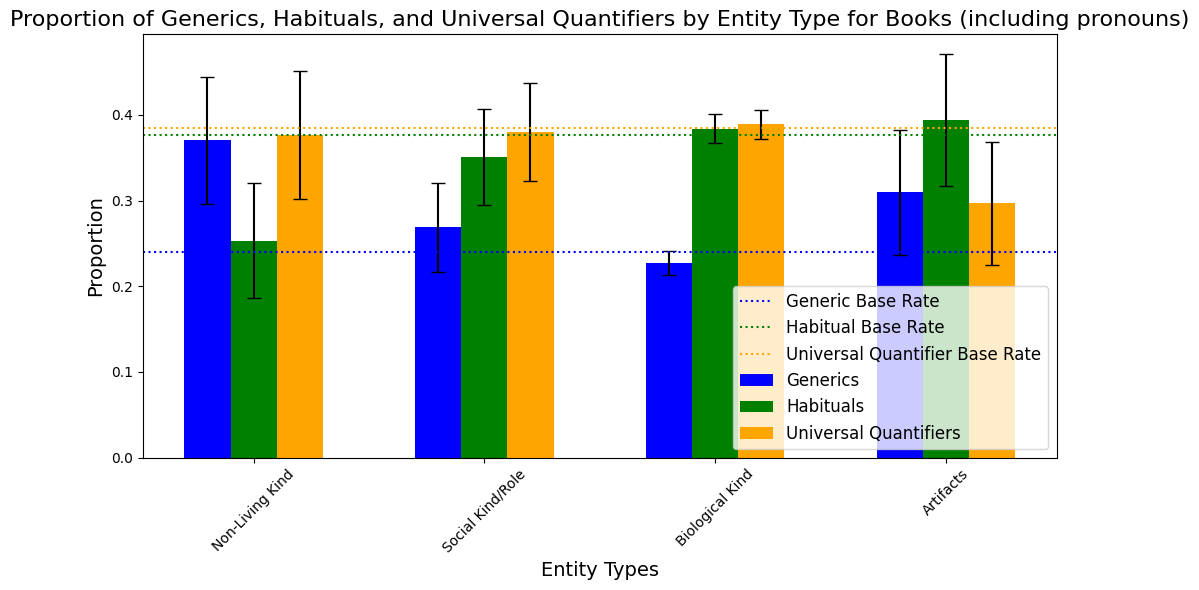

In [22]:
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Initialize the dictionary to store counts
tag_categories = {
    'Non-Living Kind': defaultdict(int),
    'Social Kind/Role': defaultdict(int),
    'Biological Kind': defaultdict(int),
    'Artifacts': defaultdict(int)
}

# Set of pronouns to exclude from "Biological Kind"
# excluded_pronouns = {'he', 'you', 'we', 'she', 'i', 'they', 'him', 'her', 'them', 'his', 'hers', 'theirs', 'it'}
excluded_pronouns = {}

# Function to process each book's sentences
def process_book(book):
    for sentence_data in book:
        subjects = sentence_data.get('subjects', [])
        tags = sentence_data.get('tags', [])
        category = sentence_data.get('category')
        quantifier = sentence_data['quantified_classification']
        
        for subject_info in subjects:
            subject = subject_info['subject'].lower()
            if subject not in excluded_pronouns:  # Check if the subject is not a pronoun
                for tag in tags:
                    if subject == tag['word'].lower():
                        entity = tag['entity']
                        if entity in tag_categories:
                            # Increment based on the quantifier and category
                            if quantifier == "Universal Quantifier":
                                tag_categories[entity]['Universal Quantifier'] += 1
                            elif category == 3:  # Generics
                                tag_categories[entity]['Generics'] += 1
                            elif category == 4:  # Habituals
                                tag_categories[entity]['Habituals'] += 1

# Process each book in the data
for book in generics_data:
    process_book(book)

# Convert defaultdict to dict for better readability
tag_categories = {k: dict(v) for k, v in tag_categories.items()}

# Calculate the total count for each tag category
total_counts = {entity: sum(categories.values()) for entity, categories in tag_categories.items()}

# Calculate base rates for Generics (category 3) and Habituals (category 4)
total_sentences = sum(total_counts.values())
generic_count = sum([category_data.get('Generics', 0) for category_data in tag_categories.values()])
habitual_count = sum([category_data.get('Habituals', 0) for category_data in tag_categories.values()])
quantifier_count = sum([category_data['Universal Quantifier'] for category_data in tag_categories.values()])

# Base rates
generic_base_rate = generic_count / total_sentences
habitual_base_rate = habitual_count / total_sentences
quantifier_base_rate = quantifier_count / total_sentences

# Calculate proportions for each category
tag_proportions = {
    entity: {category: count / total_counts[entity] for category, count in categories.items()}
    for entity, categories in tag_categories.items()
}

# Extract proportions
generics_proportions = {entity: tag_proportions[entity].get('Generics', 0) for entity in tag_proportions}
generalizing_proportions = {entity: tag_proportions[entity].get('Habituals', 0) for entity in tag_proportions}
quantifier_proportions = {entity: tag_proportions[entity]['Universal Quantifier'] for entity in tag_proportions}

# Function to calculate confidence intervals
def calculate_confidence_interval(count, total, z=1.96):  # z=1.96 for 95% CI
    if total == 0:
        return 0, 0  # Handle division by zero
    proportion = count / total
    stderr = np.sqrt(proportion * (1 - proportion) / total)
    margin_of_error = z * stderr
    return proportion - margin_of_error, proportion + margin_of_error

# Calculate error bars for each entity
entities = list(tag_categories.keys())
confidence_intervals = {
    entity: {
        'Generics': calculate_confidence_interval(tag_categories[entity].get('Generics', 0), total_counts[entity]),
        'Habituals': calculate_confidence_interval(tag_categories[entity].get('Habituals', 0), total_counts[entity]),
        'Universal Quantifier': calculate_confidence_interval(tag_categories[entity].get('Universal Quantifier', 0), total_counts[entity])
    }
    for entity in entities
}

# Extract means and error margins
generics_means = [generics_proportions[entity] for entity in entities]
generics_errors = [
    (proportion - confidence_intervals[entity]['Generics'][0], 
     confidence_intervals[entity]['Generics'][1] - proportion)
    for entity, proportion in zip(entities, generics_means)
]

habituals_means = [generalizing_proportions[entity] for entity in entities]
habituals_errors = [
    (proportion - confidence_intervals[entity]['Habituals'][0], 
     confidence_intervals[entity]['Habituals'][1] - proportion)
    for entity, proportion in zip(entities, habituals_means)
]

quantifier_means = [quantifier_proportions[entity] for entity in entities]
quantifier_errors = [
    (proportion - confidence_intervals[entity]['Universal Quantifier'][0], 
     confidence_intervals[entity]['Universal Quantifier'][1] - proportion)
    for entity, proportion in zip(entities, quantifier_means)
]

# Plotting with error bars
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(entities))  # the label locations
width = 0.2  # the width of the bars

rects1 = ax.bar(x - width, generics_means, width, label='Generics', color='blue', 
                yerr=np.array(generics_errors).T, capsize=5)
rects2 = ax.bar(x, habituals_means, width, label='Habituals', color='green', 
                yerr=np.array(habituals_errors).T, capsize=5)
rects3 = ax.bar(x + width, quantifier_means, width, label='Universal Quantifiers', color='orange', 
                yerr=np.array(quantifier_errors).T, capsize=5)

# Add base rate lines
ax.axhline(y=generic_base_rate, color='blue', linestyle='dotted', linewidth=1.5, label='Generic Base Rate')
ax.axhline(y=habitual_base_rate, color='green', linestyle='dotted', linewidth=1.5, label='Habitual Base Rate')
ax.axhline(y=quantifier_base_rate, color='orange', linestyle='dotted', linewidth=1.5, label='Universal Quantifier Base Rate')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Entity Types', fontsize=14)
ax.set_ylabel('Proportion', fontsize=14)
ax.set_title('Proportion of Generics, Habituals, and Universal Quantifiers by Entity Type for Books (including pronouns)', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(entities, fontsize=10)

# Update the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=12)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




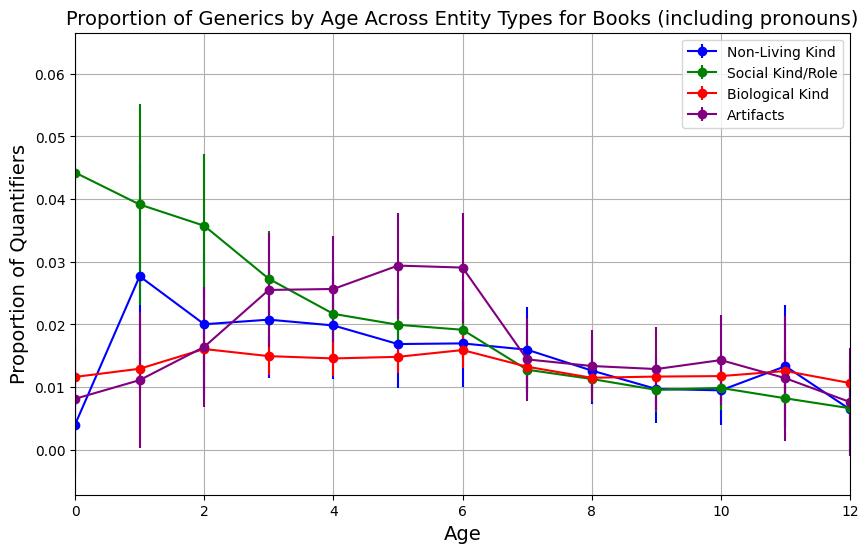

In [2]:
import json
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

# Initialize the dictionary to store counts
tag_categories = {
    'Non-Living Kind': defaultdict(Counter),
    'Social Kind/Role': defaultdict(Counter),
    'Biological Kind': defaultdict(Counter),
    'Artifacts': defaultdict(Counter)
}

# Set of pronouns to exclude from "Biological Kind"
excluded_pronouns = {'he', 'you', 'we', 'she', 'i', 'they', 'him', 'her', 'them', 'his', 'hers', 'theirs', 'it'}


# Function to process each book's sentences
def process_book(book):
    for sentence_data in book:
        subjects = sentence_data.get('subjects', [])
        tags = sentence_data.get('tags', [])
        category = sentence_data.get('category')
        quantifier = sentence_data.get('quantified_classification')
        age_min = int(sentence_data.get('age_min', 0))
        age_max = int(sentence_data.get('age_max', 0))
        
        for age in range(age_min, age_max + 1):
            for subject_info in subjects:
                subject = subject_info['subject'].lower()
                if subject not in excluded_pronouns:  # Check if the subject is not a pronoun
                    for tag in tags:
                        if subject == tag['word'].lower():
                            entity = tag['entity']
                            if entity in tag_categories:
                                tag_categories[entity][age][category] += 1

# Process each book in the data
for book in generics_data:
    process_book(book)

# Calculate the proportion of category 3 across ages for each entity
age_proportions = defaultdict(dict)
age_errors = defaultdict(dict)
for entity, age_data in tag_categories.items():
    for age, categories in age_data.items():
        total = sum(categories.values())
        if total > 0 and 4 in categories:
            age_proportions[entity][age] = categories[4] / total
            p = categories[4] / total
            se = (p * (1 - p) / total) ** 0.5  # Standard error
            age_errors[entity][age] = 1.96 * se  # 95% confidence interval
            #universal = categories.get("Universal Quantifier", 0)
            #existential = categories.get("Existential Quantifier", 0)
            #age_proportions[entity][age] = (universal + existential) / total

# Plotting the results in one plot with different colors
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red', 'purple']  # Define a list of colors for the lines
for (entity, age_data), color in zip(age_proportions.items(), colors):
    ages = sorted(age_data.keys())
    proportions = [age_data[age] for age in ages]
    errors = [age_errors[entity][age] for age in ages]
    #plt.plot(ages, proportions, marker='o', linestyle='-', label=entity, color=color)
    plt.errorbar(ages, proportions, yerr=errors, marker='o', linestyle='-', label=entity, color=color)

plt.title('Proportion of Generics by Age Across Entity Types for Books (including pronouns)', fontsize = 14)
plt.xlabel('Age', fontsize = 14)
plt.ylabel('Proportion of Quantifiers', fontsize = 14)
plt.grid(True)
plt.xlim(0, 12)
plt.legend()  # Add a legend to identify the lines
plt.show()

In [3]:
# significant testing for change across age for generics -- books

import statsmodels.api as sm
import pandas as pd

# Prepare the data for linear regression analysis
results = []
for entity, age_data in age_proportions.items():
    for age, proportion in age_data.items():
        results.append({'Entity': entity, 'Age': age, 'Proportion': proportion})

# Convert results to a DataFrame
df = pd.DataFrame(results)

# Perform regression analysis for each entity
print("Linear Regression Results (Proportion ~ Age):")
for entity in df['Entity'].unique():
    entity_data = df[df['Entity'] == entity]
    X = sm.add_constant(entity_data['Age'])  # Add constant for intercept
    y = entity_data['Proportion']
    model = sm.OLS(y, X).fit()
    
    # Print the summary of regression results
    print(f"\nEntity: {entity}")
    print(model.summary())


Linear Regression Results (Proportion ~ Age):

Entity: Non-Living Kind
                            OLS Regression Results                            
Dep. Variable:             Proportion   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     3.368
Date:                Sun, 29 Dec 2024   Prob (F-statistic):             0.0936
Time:                        21:33:46   Log-Likelihood:                 49.208
No. Observations:                  13   AIC:                            -94.42
Df Residuals:                      11   BIC:                            -93.29
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  res = hypotest_fun_out(*samples, **kwds)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  res = hypotest_fun_out(*samples, **kwds)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  res = hypotest_fun_out(*samples, **kwds)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  res = hypotest_fun_out(*samples, **kwds)


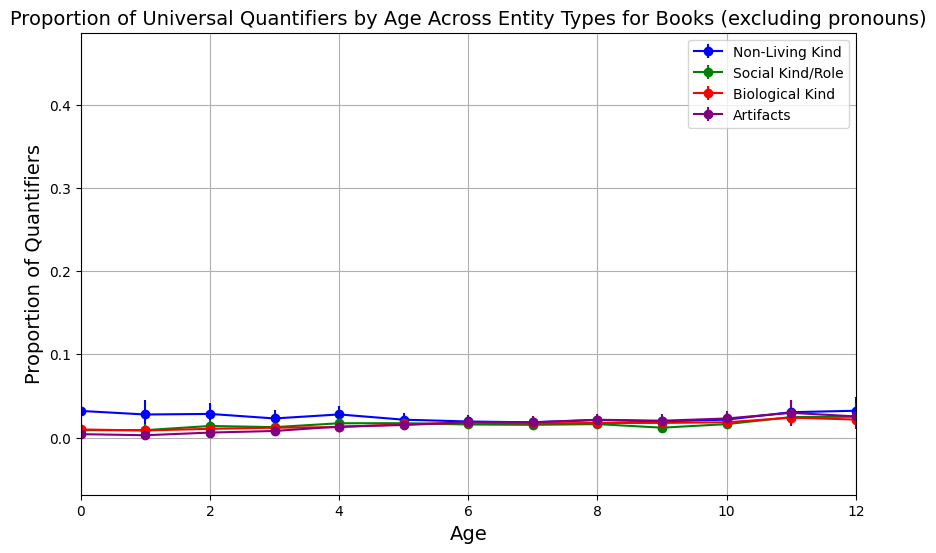

In [4]:
import json
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

# Initialize the dictionary to store counts
tag_categories = {
    'Non-Living Kind': defaultdict(Counter),
    'Social Kind/Role': defaultdict(Counter),
    'Biological Kind': defaultdict(Counter),
    'Artifacts': defaultdict(Counter)
}

# Set of pronouns to exclude from "Biological Kind"
excluded_pronouns = {'he', 'you', 'we', 'she', 'i', 'they', 'him', 'her', 'them', 'his', 'hers', 'theirs', 'it'}



# Function to process each book's sentences
def process_book(book):
    for sentence_data in book:
        subjects = sentence_data.get('subjects', [])
        tags = sentence_data.get('tags', [])
        category = sentence_data.get('category')
        quantifier = sentence_data.get('quantified_classification')
        age_min = int(sentence_data.get('age_min', 0))
        age_max = int(sentence_data.get('age_max', 0))
        
        for age in range(age_min, age_max + 1):
            for subject_info in subjects:
                subject = subject_info['subject'].lower()
                if subject not in excluded_pronouns:  # Check if the subject is not a pronoun
                    for tag in tags:
                        if subject == tag['word'].lower():
                            entity = tag['entity']
                            if entity in tag_categories:
                                tag_categories[entity][age][quantifier] += 1

# Process each book in the data
for book in generics_data:
    process_book(book)

# Calculate the proportion of category 3 across ages for each entity
age_proportions = defaultdict(dict)
age_errors = defaultdict(dict)
for entity, age_data in tag_categories.items():
    for age, categories in age_data.items():
        total = sum(categories.values())
        if total > 0 and "Universal Quantifier" in categories:
            age_proportions[entity][age] = categories["Universal Quantifier"] / total
            p = categories["Universal Quantifier"] / total
            se = (p * (1 - p) / total) ** 0.5  # Standard error
            age_errors[entity][age] = 1.96 * se  # 95% confidence interval
            #universal = categories.get("Universal Quantifier", 0)
            #existential = categories.get("Existential Quantifier", 0)
            #age_proportions[entity][age] = (universal + existential) / total

# Plotting the results in one plot with different colors
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red', 'purple']  # Define a list of colors for the lines
for (entity, age_data), color in zip(age_proportions.items(), colors):
    ages = sorted(age_data.keys())
    proportions = [age_data[age] for age in ages]
    errors = [age_errors[entity][age] for age in ages]
    #plt.plot(ages, proportions, marker='o', linestyle='-', label=entity, color=color)
    plt.errorbar(ages, proportions, yerr=errors, marker='o', linestyle='-', label=entity, color=color)

plt.title('Proportion of Universal Quantifiers by Age Across Entity Types for Books (excluding pronouns)', fontsize = 14)
plt.xlabel('Age', fontsize = 14)
plt.ylabel('Proportion of Quantifiers', fontsize = 14)
plt.grid(True)
plt.xlim(0, 12)
plt.legend()  # Add a legend to identify the lines
plt.show()

In [5]:
# significant testing for change across age for generics -- books

import statsmodels.api as sm
import pandas as pd

# Prepare the data for linear regression analysis
results = []
for entity, age_data in age_proportions.items():
    for age, proportion in age_data.items():
        results.append({'Entity': entity, 'Age': age, 'Proportion': proportion})

# Convert results to a DataFrame
df = pd.DataFrame(results)

# Perform regression analysis for each entity
print("Linear Regression Results (Proportion ~ Age):")
for entity in df['Entity'].unique():
    entity_data = df[df['Entity'] == entity]
    X = sm.add_constant(entity_data['Age'])  # Add constant for intercept
    y = entity_data['Proportion']
    model = sm.OLS(y, X).fit()
    
    # Print the summary of regression results
    print(f"\nEntity: {entity}")
    print(model.summary())


Linear Regression Results (Proportion ~ Age):

Entity: Non-Living Kind
                            OLS Regression Results                            
Dep. Variable:             Proportion   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                 -0.061
Method:                 Least Squares   F-statistic:                    0.3135
Date:                Sun, 29 Dec 2024   Prob (F-statistic):              0.587
Time:                        21:40:59   Log-Likelihood:                 50.921
No. Observations:                  13   AIC:                            -97.84
Df Residuals:                      11   BIC:                            -96.71
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  res = hypotest_fun_out(*samples, **kwds)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  res = hypotest_fun_out(*samples, **kwds)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  res = hypotest_fun_out(*samples, **kwds)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  res = hypotest_fun_out(*samples, **kwds)


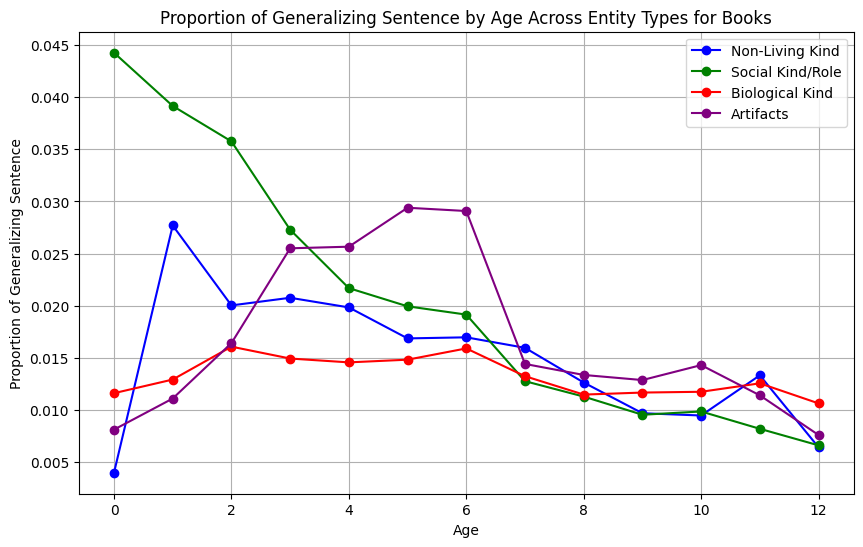

In [15]:
import json
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

# Initialize the dictionary to store counts
tag_categories = {
    'Non-Living Kind': defaultdict(Counter),
    'Social Kind/Role': defaultdict(Counter),
    'Biological Kind': defaultdict(Counter),
    'Artifacts': defaultdict(Counter)
}

# Set of pronouns to exclude from "Biological Kind"
excluded_pronouns = {'he', 'you', 'we', 'she', 'i', 'they', 'him', 'her', 'them', 'his', 'hers', 'theirs', 'it'}

# Function to process each book's sentences
def process_book(book):
    for sentence_data in book:
        subjects = sentence_data.get('subjects', [])
        tags = sentence_data.get('tags', [])
        category = sentence_data.get('category')
        age_min = int(sentence_data.get('age_min', 0))
        age_max = int(sentence_data.get('age_max', 0))
        
        for age in range(age_min, age_max + 1):
            for subject_info in subjects:
                subject = subject_info['subject'].lower()
                if subject not in excluded_pronouns:  # Check if the subject is not a pronoun
                    for tag in tags:
                        if subject == tag['word'].lower():
                            entity = tag['entity']
                            if entity in tag_categories:
                                tag_categories[entity][age][category] += 1

# Process each book in the data
for book in generics_data:
    process_book(book)

# Calculate the proportion of category 4 across ages for each entity
age_proportions = defaultdict(dict)
for entity, age_data in tag_categories.items():
    for age, categories in age_data.items():
        total = sum(categories.values())
        if total > 0 and 4 in categories:
            age_proportions[entity][age] = categories[4] / total

# Plotting the results in one plot with different colors
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red', 'purple']  # Define a list of colors for the lines
for (entity, age_data), color in zip(age_proportions.items(), colors):
    ages = sorted(age_data.keys())
    proportions = [age_data[age] for age in ages]
    plt.plot(ages, proportions, marker='o', linestyle='-', label=entity, color=color)

plt.title('Proportion of Generalizing Sentence by Age Across Entity Types for Books')
plt.xlabel('Age')
plt.ylabel('Proportion of Generalizing Sentence')
plt.grid(True)
plt.legend()  # Add a legend to identify the lines
plt.show()